# Faster R-CNN-Anchor and Region Proposal Network Targets
## Import modules and load configurations

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from config.config import Config
from src.data_generator import VOCData
from src.visualize import draw_box
from src.model import get_rpn_target, generate_anchors, unparameterize_box, box_iou, yxyx_to_xyctrwh, xyctrwh_to_yxyx

# increase image resolution for jupyter notebook
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

# load config
config = Config()

Configuration is loaded: 
{'LR': 0.0001, 'DECAY': 0.0005, 'BATCH_SIZE': 8, 'EPOCH': 10000, 'DETECTION_NMS_IOU': 0.5, 'DETECTION_NMS_MAX_NUM': 100, 'INPUT_SHAPE': [600, 1000, 3], 'NUM_CLASS': 20, 'MAX_GT_INSTANCE': 50, 'BACKBONE': None, 'FEATURE_SHAPE': [37, 62], 'ANCHOR_NUM': 9, 'ANCHOR_SCALES': [128, 256, 512], 'ANCHOR_RATIOS': [0.5, 1.0, 2.0], 'FEATRUE_STRIDE': 16, 'ANCHOR_STRIDE': 1, 'RPN_POS_IOU_THOLD': 0.7, 'RPN_NEG_IOU_THOLD': 0.3, 'RPN_TOTAL_SAMPLE_NUM': 256, 'RPN_POS_SAMPLE_RATIO': 0.5, 'RPN_LAMBDA': 10.0, 'RPN_NMS_NUM': 2000, 'RPN_NMS_IOU': 0.7, 'RCNN_ROI_POOL_SIZE': 7, 'RCNN_POS_IOU_THOLD': 0.5, 'RCNN_NEG_IOU_THOLD': 0.1, 'RCNN_TOTAL_SAMPLE_NUM': 64, 'RCNN_POS_SAMPLE_RATIO': 0.25, 'RCNN_LAMDA': 1.0}


## Load Train Dataset

In [2]:
# load dataset
train_data_dir = 'dataset/VOC2007/trainval/VOCdevkit/VOC2007'
train_dataset = VOCData(train_data_dir,
                        config.INPUT_SHAPE,
                        batch_size=config.BATCH_SIZE,
                        max_gt_instance=config.MAX_GT_INSTANCE,
                        debug=True)

Load from: dataset/VOC2007/trainval/VOCdevkit/VOC2007
DEBUD MODE: True
Batch size: 8
Images: 8
Classes: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']



## Inspect Anchors
### 1. Visualize whole anchors

Anchor Configurations
[CONFIG] anchor scales: [128, 256, 512]
[CONFIG] anchor ratios: [0.5, 1.0, 2.0]

# of anchors = feature_map_height(37) x feature_map_width(62) x num_anchors(9): 20646


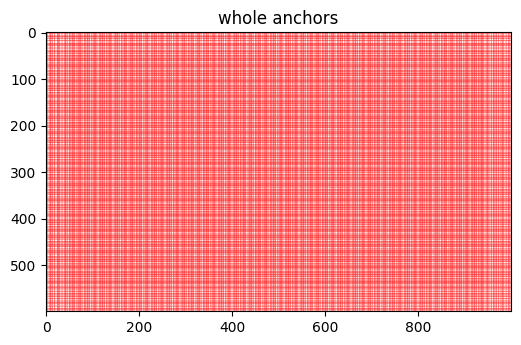

In [4]:
# create white empty image for visualization
white_img = np.zeros([600, 1000, 3], dtype='uint8') + 255

# generate anchors
anchors = generate_anchors(
    config.ANCHOR_SCALES,
    config.ANCHOR_RATIOS,
    config.FEATURE_SHAPE,
    config.FEATRUE_STRIDE,
    config.ANCHOR_STRIDE
    )
print("Anchor Configurations")
print("[CONFIG] anchor scales: {}".format(config.ANCHOR_SCALES))
print("[CONFIG] anchor ratios: {}\n".format(config.ANCHOR_RATIOS))

# visualize whole anchors
print("# of anchors = feature_map_height({}) x feature_map_width({}) x num_anchors({}): {}".format(
    config.FEATURE_SHAPE[0], config.FEATURE_SHAPE[1], config.ANCHOR_NUM, len(anchors)))
anchor_img = white_img.copy()
for anchor in anchors:
    anchor_img = draw_box(anchor_img, anchor, thickness=1)
plt.imshow(anchor_img)
plt.title("whole anchors")
plt.show()

### 2. Visualize inner anchors 

# of inner anchors: 7856


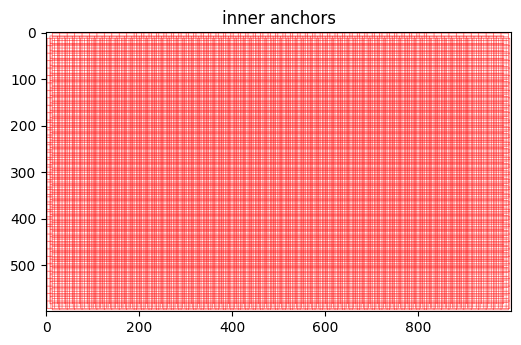

In [5]:
# get inner anchors
inner_anchor_bool_mask = np.where(
        (anchors[:, 0] >= 0) &
        (anchors[:, 1] >= 0) &
        (anchors[:, 2] < config.INPUT_SHAPE[0]) &
        (anchors[:, 3] < config.INPUT_SHAPE[1]),
        True,
        False,
        )
inner_anchors = anchors[inner_anchor_bool_mask]

# visualize inner anchors
print("# of inner anchors: {}".format(len(inner_anchors)))
inner_anchor_img = white_img.copy()
for innner_anchor in inner_anchors:
    inner_anchor_img = draw_box(inner_anchor_img, innner_anchor, thickness=1)
plt.imshow(inner_anchor_img)
plt.title("inner anchors")
plt.show()    

### 3. Visualize one set of anchors

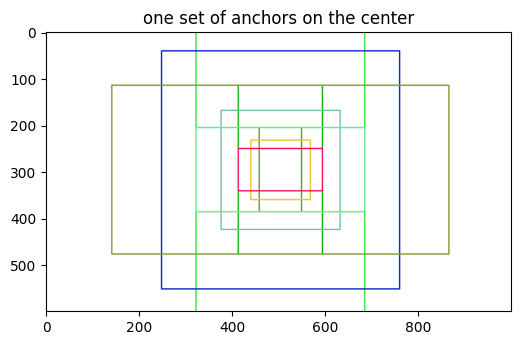

In [6]:
# get feature center posistion
feature_x_ctr = int(config.FEATURE_SHAPE[1]/2.)
feature_y_ctr = int(config.FEATURE_SHAPE[0]/2.)

# get one anchor set on the center
anchor_idx = feature_y_ctr*config.FEATURE_SHAPE[1]*config.ANCHOR_NUM + feature_x_ctr*config.ANCHOR_NUM
one_set_anchors = anchors[anchor_idx:anchor_idx+config.ANCHOR_NUM]

anchor_set_img = white_img.copy()
for anchor in one_set_anchors:
    color = np.random.randint(0, 255, size=3).tolist()
    anchor_set_img = draw_box(anchor_set_img, anchor, color=color, thickness=2)
plt.imshow(anchor_set_img)
plt.title("one set of anchors on the center")
plt.show()

## Choose Data Point Index
If you want see different results from the other image, change the `idx` parameter in range [0, 7]

In [7]:
# data point
idx = 5
print("{} th image results.".format(idx))

5 th image results.


## Region Proposal Network Targets

In [8]:
# get one batch data from the dataset
img_batch, (gt_cls_ids, gt_boxes, num_gt_instance) = train_dataset[0]
rpn_targets = tf.map_fn(
    fn=lambda i: get_rpn_target(
        anchors,
        gt_boxes[i][:num_gt_instance[i]],
        # gt_box,
        image_shape=config.INPUT_SHAPE,
        pos_threshold=config.RPN_POS_IOU_THOLD,
        neg_threshold=config.RPN_NEG_IOU_THOLD,
        total_sample_num=config.RPN_TOTAL_SAMPLE_NUM,
        pos_sample_ratio=config.RPN_POS_SAMPLE_RATIO),
    elems=tf.range(config.BATCH_SIZE),
    # elems=num_gt_instance,
    fn_output_signature=(
        tf.TensorSpec(shape=[config.RPN_TOTAL_SAMPLE_NUM], dtype=tf.int32),
        tf.TensorSpec(shape=[config.RPN_TOTAL_SAMPLE_NUM, 4], dtype=tf.float32),
        tf.TensorSpec(shape=[config.RPN_TOTAL_SAMPLE_NUM], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.int32),),
    parallel_iterations=config.BATCH_SIZE,
    )

# unpack rpn_targets and make numpy
rpn_cls_target = rpn_targets[0][idx].numpy()
rpn_reg_target = rpn_targets[1][idx].numpy()
rpn_train_indices = rpn_targets[2][idx].numpy()
rpn_pos_num = rpn_targets[3][idx].numpy()
rpn_neg_num = len(rpn_train_indices) - rpn_pos_num

# print configuations and results
print("RPN Configurations")
print("[CONFIG] # of samples: {}".format(config.RPN_TOTAL_SAMPLE_NUM))
print("[CONFIG] Positive sample ratio: {}".format(config.RPN_POS_SAMPLE_RATIO))
print("[CONFIG] Positive IoU threshold: {}".format(config.RPN_POS_IOU_THOLD))
print("[CONFIG] Negative IoU threshold: {}\n".format(config.RPN_NEG_IOU_THOLD))

print("RPN Target Results")
print("[RESULT] # of total samples: {}".format(len(rpn_train_indices)))
print("[RESULT] # of positive samples: {}".format(rpn_pos_num))
print("[RESULT] # of negative samples: {}".format(rpn_neg_num))

RPN Configurations
[CONFIG] # of samples: 256
[CONFIG] Positive sample ratio: 0.5
[CONFIG] Positive IoU threshold: 0.7
[CONFIG] Negative IoU threshold: 0.3

RPN Target Results
[RESULT] # of total samples: 256
[RESULT] # of positive samples: 59
[RESULT] # of negative samples: 197


### Visulize RPN positive and negative target anchors

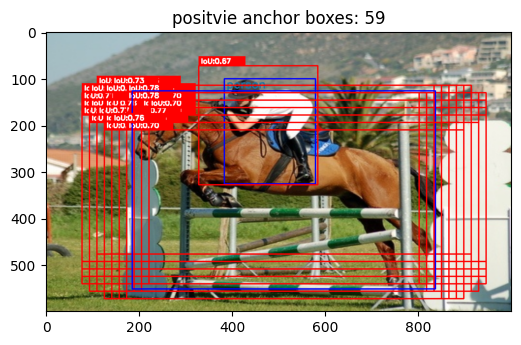

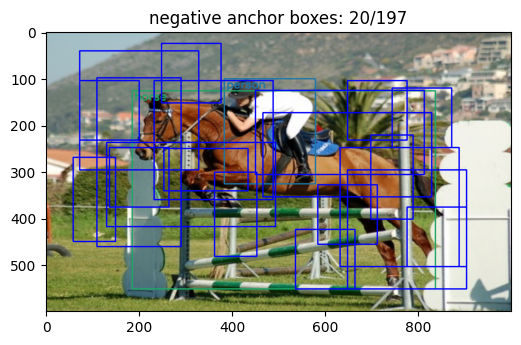

In [9]:
# unparameterize the positive target boxes
pos_rpn_target_boxes = unparameterize_box(
    rpn_reg_target[:rpn_pos_num], yxyx_to_xyctrwh(anchors[rpn_train_indices[:rpn_pos_num]]))
pos_rpn_target_boxes = xyctrwh_to_yxyx(pos_rpn_target_boxes)

# get pos/neg anchors
pos_anchor_boxes = anchors[rpn_train_indices[:rpn_pos_num]]
neg_anchor_boxes = anchors[rpn_train_indices[rpn_pos_num:]]

# get region proposal target boxes
gt_box_img = train_dataset.draw_label_img(
    img_batch[idx],
    gt_cls_ids[idx][:num_gt_instance[idx]],
    gt_boxes[idx][:num_gt_instance[idx]])

# show pos anchors
pos_target_anchor_boxes = zip(pos_rpn_target_boxes, pos_anchor_boxes)
pos_anchor_image = gt_box_img.copy()
for pos_target_box, pos_anchor_box in pos_target_anchor_boxes:
    iou = box_iou(
        np.expand_dims(pos_target_box, axis=0),
        np.expand_dims(pos_anchor_box, axis=0))[0][0]
    pos_anchor_image = draw_box(pos_anchor_image, pos_target_box, color=[0,0,255])
    pos_anchor_image = draw_box(pos_anchor_image, pos_anchor_box, "IoU:{:.2f}".format(iou))
plt.imshow(pos_anchor_image)
plt.title("positvie anchor boxes: {}".format(rpn_pos_num))
plt.show()

# show pos anchors
neg_anchor_image = gt_box_img.copy()
neg_anchor_boxes = neg_anchor_boxes[:20]
for neg_anchor_box in neg_anchor_boxes:
    neg_anchor_image = draw_box(neg_anchor_image, neg_anchor_box, color=[0,0,255])
plt.imshow(neg_anchor_image)
plt.title("negative anchor boxes: {}/{}".format(20, rpn_neg_num))
plt.show()